In [ ]:
# Code written by Abhiroop Chintalapudi-AI20BTECH11005, and co-authored with the help of Mudavath Rohith-EE20BTECH11031
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Load the image
tree = mpimg.imread('tree.jpeg')
iith = mpimg.imread('IITH LOGO.jpg')

# plt.imshow(tree)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(-0.5, 703.5, 287.5, -0.5)

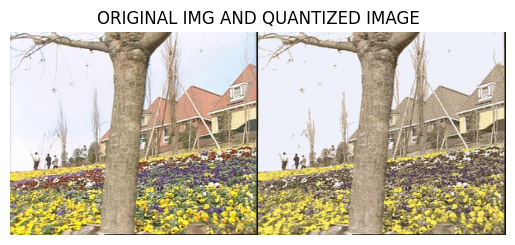

In [ ]:
# quantization of image
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import argparse
import cv2

# find height and width of the image
image = cv2.imread('tree.jpeg')
(h, w) = image.shape[:2]

#convert BGR to LAB
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

image = image.reshape((image.shape[0] * image.shape[1], 3))
# create quantized image based on the predictions of k-means clusturing
clt = MiniBatchKMeans(n_clusters = 16)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]
# reshape the feature vectors to images
quant = quant.reshape((h, w, 3))
image = image.reshape((h, w, 3))
# convert LAB image back to BGR
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)

plt.imshow(np.hstack([tree, quant]))
plt.title('ORIGINAL IMG AND QUANTIZED IMAGE')
plt.axis('off')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(-0.5, 351.5, 287.5, -0.5)

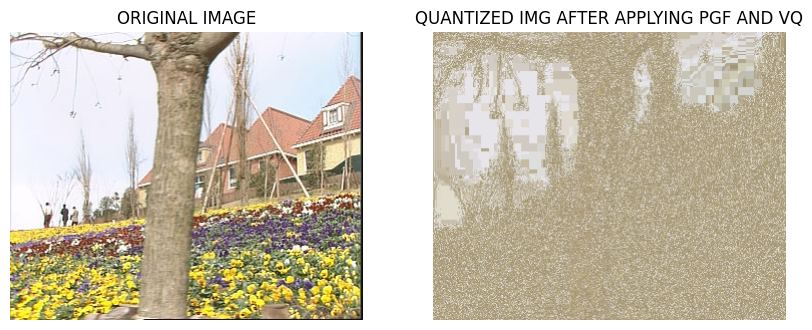

In [ ]:
# Reshape the image to a 2D array of pixels
pixel_array = np.reshape(tree, (-1, tree.shape[-1]))

# Define the number of colors to reduce the image to
num_colors = 256

# Initialize the codebook using K-means clustering
codebook = pixel_array[np.random.choice(pixel_array.shape[0], num_colors, replace=False), :]

# Perform PGF and VQ on the pixel array
for i in range(30):
    # Assign each pixel to its nearest codebook vector
    codes = np.argmin(np.sum((pixel_array[:, np.newaxis, :] - codebook[np.newaxis, :, :]) ** 2, axis=2), axis=1)
    
    # Update the codebook using the mean of each group of pixels assigned to the same code
    for j in range(num_colors):
        codebook[j] = np.mean(pixel_array[codes == j], axis=0)
    
# Replace each pixel with its nearest codebook vector
quantized_pixel_array = codebook[codes, :]

# Reshape the quantized pixel array back into an image
quantized_img = np.reshape(quantized_pixel_array, tree.shape)

# Display the original and quantized images side by side
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plt.imshow(tree)
plt.axis('off')
plt.title('ORIGINAL IMAGE')
ax = plt.subplot(1,2,2)
plt.imshow(quantized_img)
plt.title('QUANTIZED IMG AFTER APPLYING PGF AND VQ')
plt.axis('off')

(-0.5, 351.5, 287.5, -0.5)

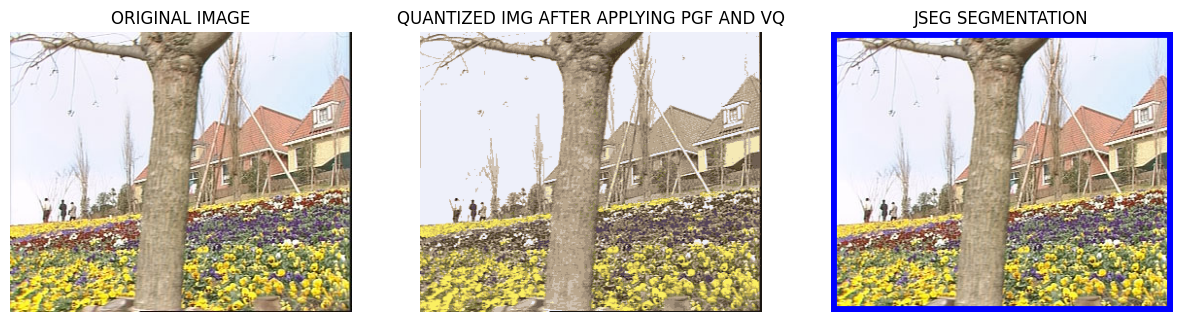

In [ ]:
# convert BGR image to RGB
def cvt_clr(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return a

def JSEG_segmentation(image):
    image = image[:,:,:3]
    # Convert RGB image to LAB image
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Extract Luminance from LAB image
    L, A, B = cv2.split(lab)
    # Compute gradient magnitude and orientation
    dx = cv2.Sobel(L, cv2.CV_64F, 1, 0)
    dy = cv2.Sobel(L, cv2.CV_64F, 0, 1)
    gradient_magnitude = cv2.magnitude(dx, dy)
    gradient_orientation = cv2.phase(dx, dy, angleInDegrees=True)
    
    # Quantize gradient orientation
    num_bins = 25
    bin_size = 360 / num_bins
    quantized_orientation = np.round(gradient_orientation / bin_size) % num_bins
    
    # Apply J-Linkage Segmentation
    threshold = 0.2
    segment_size = 1
    segments = np.zeros_like(L)
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if segments[i, j] == 0:
                segment = np.zeros_like(L, dtype=np.uint8)
                segment_indices = [(i, j)]
                while len(segment_indices) > 0:
                    idx = segment_indices.pop()
                    segment[idx] = 1
                    neighbors = [(idx[0]-1, idx[1]-1), (idx[0]-1, idx[1]), (idx[0]-1, idx[1]+1),
                                 (idx[0], idx[1]-1), (idx[0], idx[1]+1),
                                 (idx[0]+1, idx[1]-1), (idx[0]+1, idx[1]), (idx[0]+1, idx[1]+1)]
                    for neighbor in neighbors:
                        if neighbor[0] >= 0 and neighbor[0] < L.shape[0] and neighbor[1] >= 0 and neighbor[1] < L.shape[1]:
                            if segments[neighbor] == 0 and abs(quantized_orientation[idx] - quantized_orientation[neighbor]) < threshold and gradient_magnitude[idx] > gradient_magnitude[neighbor]:
                                segment_indices.append(neighbor)
                if np.sum(segment) > segment_size:
                    segments += segment * np.max(segments) + 1
    
    result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(np.unique(segments,return_counts=True))
    for i in range(1, np.max(segments)+1):
        mask = np.where(segments == i, 100, 0).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result, contours, -1, (255, 0, 0), thickness=10)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return cvt_clr(result)

jseg_img = JSEG_segmentation(tree)
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
plt.imshow(tree)
plt.axis('off')
plt.title('ORIGINAL IMAGE')
ax = plt.subplot(1,3,2)
plt.imshow(quant)
plt.title('QUANTIZED IMG AFTER APPLYING PGF AND VQ')
plt.axis('off')
ax = plt.subplot(1,3,3)
plt.imshow(jseg_img)
plt.title('JSEG SEGMENTATION')
plt.axis('off')


(-0.5, 473.5, 295.5, -0.5)

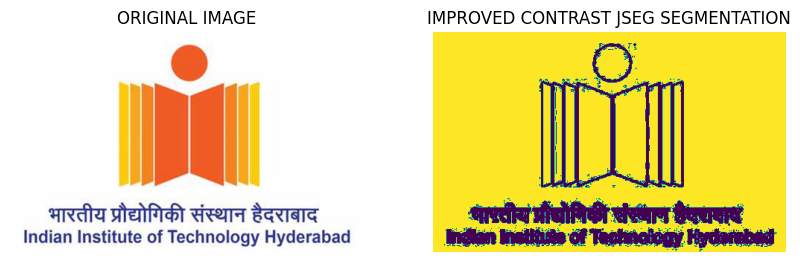

In [ ]:
def jseg_segmentation(img):
    
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Normalize the image
    img_norm = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Compute magnitude and direction of gradient
    Gx = cv2.Sobel(img_norm, cv2.CV_32F, 1, 0, ksize=3)
    Gy = cv2.Sobel(img_norm, cv2.CV_32F, 0, 1, ksize=3)
    M = cv2.magnitude(Gx, Gy)
    theta = cv2.phase(Gx, Gy, angleInDegrees=True)

    # Apply threshold segmentation
    T = np.mean(M) / 2
    seg = np.uint8(M >= T) * 255

    # Compute region mean and variance
    mean_r = []
    var_r = []
    for k in range(256):
        pixels = img_norm[seg == k]
        if len(pixels) > 0:
            mean_r.append(np.mean(pixels))
            var_r.append(np.var(pixels))

    # Compute global mean and variance
    mean_g = np.mean(mean_r)
    var_g = np.mean(var_r)

    # Compute threshold for merging regions
    T_merge = var_g / (2 * math.log(img_norm.size))

    # Merge the regions again
    seg_merge = np.zeros(seg.shape)
    for k in range(len(var_r)):
        pixels = img_norm[seg == k]
        if len(pixels) > 0:
            if var_r[k] < T_merge:
                seg_merge[seg == k] = 255
            else:
                if mean_r[k] > mean_g:
                    seg_merge[seg == k] = 255
                else:
                    seg_merge[seg == k] = 0

    return seg_merge

imp_contrastimg = jseg_segmentation(iith)
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
plt.imshow(iith)
plt.axis('off')
plt.title('ORIGINAL IMAGE')
ax = plt.subplot(1,2,2)
plt.imshow(imp_contrastimg)
plt.title('IMPROVED CONTRAST JSEG SEGMENTATION')
plt.axis('off')

In [ ]:
# plt.imsave('quant.jpeg',quant)

In [ ]:
# plt.imsave('quantized_img.jpeg',quantized_img)

In [ ]:
# plt.imsave('jseg_img.jpeg',jseg_img)

In [ ]:
# plt.imsave('ICimg.jpeg',imp_contrastimg)